In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # subplots
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv("breast_cancer_data.csv",header = 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
# size of the dataframe
len(df)

569

In [4]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

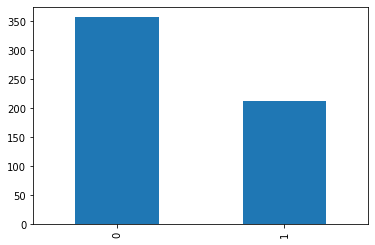

In [5]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.diagnosis.value_counts()[0:30].plot(kind='bar')
plt.show()

In [6]:
features_mean=list(df.columns[1:11])
# split dataframe into two based on diagnosis
dfM=df[df['diagnosis'] ==1]
dfB=df[df['diagnosis'] ==0]

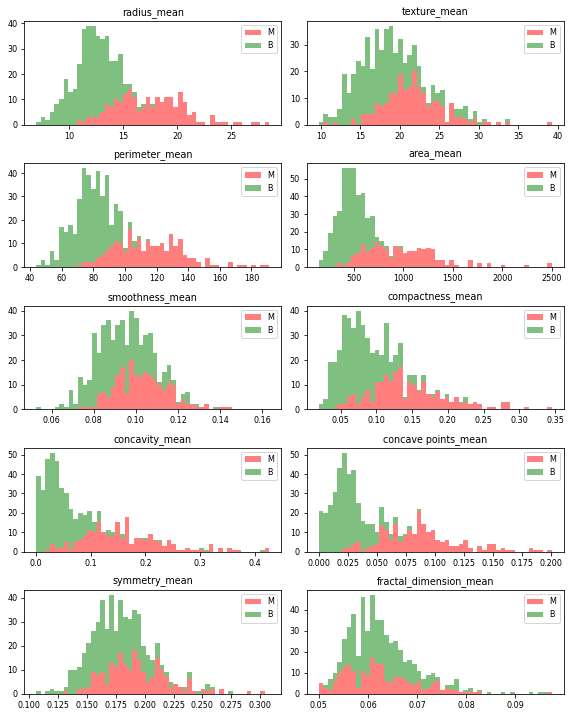

In [7]:
#Stack the data
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], bins=np.arange(min(df[features_mean[idx]]), max(df[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True,  label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

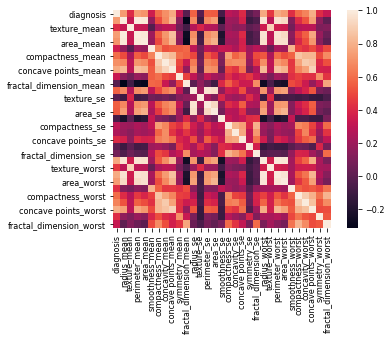

In [8]:
cor = df.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map
plt.show()

In [9]:
Y = df['diagnosis']
X = df.drop(columns=['diagnosis'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=786)

In [10]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)

X train shape:  (398, 30)
Y train shape:  (398,)
X test shape:  (171, 30)
Y test shape:  (171,)


In [11]:
def classification_model(model, model_name, X_train, X_test, Y_train, Y_test, predictors=None):
    
    if predictors is None:
        predictors = X_train.columns
    
    #Fit the model:
    model.fit(X_train[predictors],Y_train)

    #Make predictions on training set:
    train_predictions = model.predict(X_train[predictors])
    
    #Make predictions on test set:
    test_predictions = model.predict(X_test[predictors])
    
    print(f"Printing Stats for {model_name}")

    #Print accuracy
    train_accuracy = metrics.accuracy_score(train_predictions,Y_train)
    train_average_precision = metrics.average_precision_score(train_predictions, Y_train)
    
    test_accuracy = metrics.accuracy_score(test_predictions,Y_test)
    test_average_precision = metrics.average_precision_score(test_predictions, Y_test)

    print('Training Average precision-recall score: {0:0.2f}'.format(
      train_average_precision))
    print(f"Training Accuracy : %s" % "{0:.3%}".format(train_accuracy))
    
    print('Testing Average precision-recall score: {0:0.2f}'.format(
      test_average_precision))
    print(f"Testing Accuracy : %s" % "{0:.3%}".format(test_accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(X_train):
        # Filter training data
        train_predictors = (X_train[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = Y_train.iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(X_train[predictors].iloc[test,:], Y_train.iloc[test]))

        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(X_train[predictors],Y_train)

    logreg_cm = metrics.confusion_matrix(Y_test, test_predictions)
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(logreg_cm, annot=True, linewidth=0.7, linecolor='red', fmt='g', ax=ax, cmap="BuPu")
    plt.title(f'{model_name} Classification Confusion Matrix')
    plt.xlabel('Y predict')
    plt.ylabel('Y test')
    plt.show()

Printing Stats for Logistic Regression
Training Average precision-recall score: 0.74
Training Accuracy : 88.191%
Testing Average precision-recall score: 0.78
Testing Accuracy : 91.813%
Cross-Validation Score : 86.250%
Cross-Validation Score : 89.375%
Cross-Validation Score : 88.750%
Cross-Validation Score : 89.031%
Cross-Validation Score : 88.187%


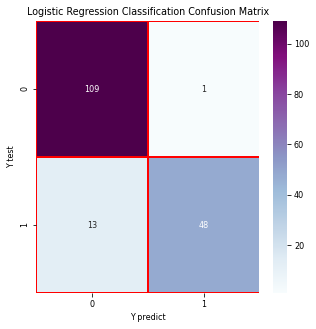

In [12]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
model=LogisticRegression()
classification_model(model, 'Logistic Regression', X_train, X_test, Y_train, Y_test, predictor_var)

Printing Stats for Decision Tree
Training Average precision-recall score: 1.00
Training Accuracy : 100.000%
Testing Average precision-recall score: 0.80
Testing Accuracy : 91.228%
Cross-Validation Score : 85.000%
Cross-Validation Score : 90.625%
Cross-Validation Score : 90.000%
Cross-Validation Score : 90.918%
Cross-Validation Score : 90.709%


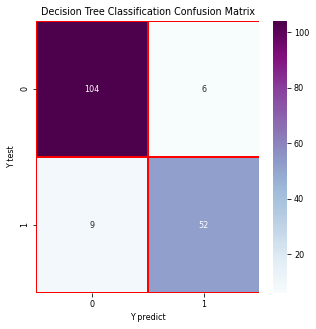

In [13]:
# Overfitting
model = DecisionTreeClassifier()
classification_model(model, 'Decision Tree', X_train, X_test, Y_train, Y_test, None)

Printing Stats for Decision Tree
Training Average precision-recall score: 0.91
Training Accuracy : 96.482%
Testing Average precision-recall score: 0.65
Testing Accuracy : 83.626%
Cross-Validation Score : 78.750%
Cross-Validation Score : 83.125%
Cross-Validation Score : 83.333%
Cross-Validation Score : 81.487%
Cross-Validation Score : 81.392%


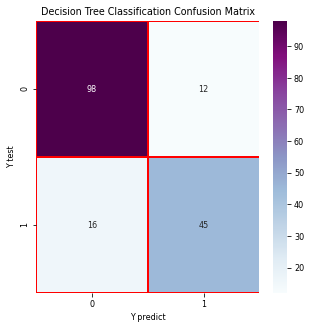

In [14]:
predictor_var = ['radius_mean']
model = DecisionTreeClassifier()
classification_model(model, 'Decision Tree', X_train, X_test, Y_train, Y_test, predictor_var)

Printing Stats for Random Forest
Training Average precision-recall score: 0.91
Training Accuracy : 95.729%
Testing Average precision-recall score: 0.83
Testing Accuracy : 93.567%
Cross-Validation Score : 91.250%
Cross-Validation Score : 91.250%
Cross-Validation Score : 91.667%
Cross-Validation Score : 92.801%
Cross-Validation Score : 92.722%


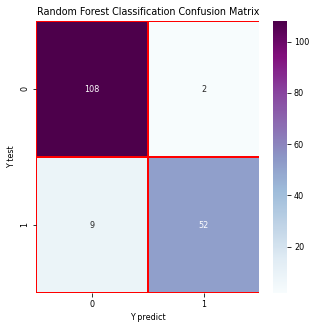

In [15]:
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, 'Random Forest' , X_train, X_test, Y_train, Y_test, features_mean)

In [16]:
featimp = pd.Series(model.feature_importances_, index=features_mean).sort_values(ascending=False)
print(featimp)

concave points_mean       0.263177
radius_mean               0.172950
area_mean                 0.151009
perimeter_mean            0.135009
concavity_mean            0.109025
compactness_mean          0.071619
texture_mean              0.045450
smoothness_mean           0.024593
symmetry_mean             0.014224
fractal_dimension_mean    0.012943
dtype: float64


Printing Stats for Random Forest
Training Average precision-recall score: 0.88
Training Accuracy : 94.221%
Testing Average precision-recall score: 0.84
Testing Accuracy : 93.567%
Cross-Validation Score : 90.000%
Cross-Validation Score : 90.625%
Cross-Validation Score : 90.833%
Cross-Validation Score : 92.176%
Cross-Validation Score : 92.222%


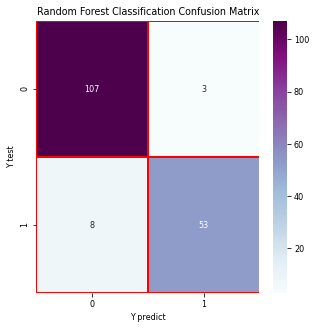

In [17]:
# Using top 5 features

model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, 'Random Forest' , X_train, X_test, Y_train, Y_test, featimp.head(5).index)

Printing Stats for SVM
Training Average precision-recall score: 0.72
Training Accuracy : 88.442%
Testing Average precision-recall score: 0.75
Testing Accuracy : 90.643%
Cross-Validation Score : 87.500%
Cross-Validation Score : 88.750%
Cross-Validation Score : 87.917%
Cross-Validation Score : 87.140%
Cross-Validation Score : 87.180%


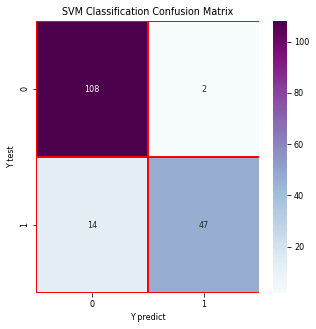

In [18]:
# We define the SVM model
model = OneVsRestClassifier(BaggingClassifier(SVC(C=10,kernel='rbf',random_state=9, probability=True), 
                                               n_jobs=-1))
classification_model(model, 'SVM' , X_train, X_test, Y_train, Y_test, features_mean)

Printing Stats for Naive Bayes
Training Average precision-recall score: 0.86
Training Accuracy : 94.221%
Testing Average precision-recall score: 0.87
Testing Accuracy : 95.322%
Cross-Validation Score : 91.250%
Cross-Validation Score : 93.125%
Cross-Validation Score : 93.333%
Cross-Validation Score : 94.051%
Cross-Validation Score : 93.468%


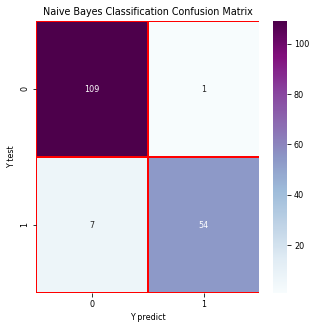

In [19]:
# We define the NB model
model = GaussianNB()
classification_model(model, 'Naive Bayes' , X_train, X_test, Y_train, Y_test, None)

Printing Stats for KNN
Training Average precision-recall score: 0.86
Training Accuracy : 94.221%
Testing Average precision-recall score: 0.87
Testing Accuracy : 95.322%
Cross-Validation Score : 91.250%
Cross-Validation Score : 93.125%
Cross-Validation Score : 93.333%
Cross-Validation Score : 94.051%
Cross-Validation Score : 93.468%


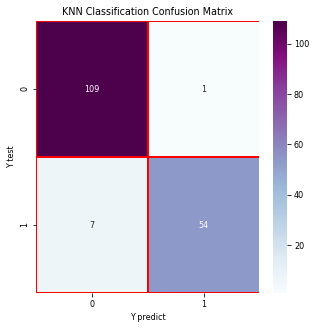

In [20]:
# We define the KNN model
model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
classification_model(model, 'KNN' , X_train, X_test, Y_train, Y_test, None)